In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import streetview # Thanks to https://github.com/cplusx/google-street-view-panorama-download
from skimage import io
import numpy as np
import os
import cv2
import pathlib

In [3]:
# Go to https://map.project-osrm.org/
# Draw your path and click the button: Export GPX file
# Then, put your file path here
file_path = "./route.gpx"

In [53]:
def get_lat_long(file_path: str) -> list:
    """Function to load the file and get latitudes and longitudes of the path"""
    with open(file_path) as f:
        content = f.readlines()[1]
        content = content.split("<trkseg>")[1]
        content = content.split("</trkseg>")[0]
        lat_longs = []
        for coords in content.split("lat")[1:]:
            lat, lon = coords.split(" ")[0][1:], coords.split(" ")[1][4:]
            lon = lon[:lon.find("/")]
            lat, lon = eval(lat), eval(lon)
            lat_longs.append((float(lat), float(lon)))
    return lat_longs

def check_path(path: str) -> None:
    """Make sure a path exists"""
    path = pathlib.Path(path)
    if not path.exists():
        path.mkdir(parents=True)

def expand_lat_lon(lat_lon: tuple, lat_lon_before: tuple) -> list:
    """Expand latitude longitude to get more images between two points"""
    lat, lon = lat_lon
    lat_before, lon_before = lat_lon_before
    diff_lat = lat - lat_before
    diff_lon = lon - lon_before
    step_size = 3e-5
    steps_lat = abs(diff_lat) / 1e-5
    steps_lon = abs(diff_lon) / 1e-5
    factor_lat = step_size if diff_lat > 0 else -step_size
    factor_lon = step_size if diff_lon > 0 else -step_size
    jumps = round(max([steps_lat, steps_lon]) / min([steps_lat, steps_lon]))
    expanded = []

    for i in range(int(max([steps_lat, steps_lon]))):

        if not (i % jumps):
            # Find the smaller one
            if steps_lat <= steps_lon:
                lat += factor_lat
            else:
                lon += factor_lon

        # Find the bigger one
        if steps_lat >= steps_lon:
            lat += factor_lat
        else:
            lon += factor_lon
        
        expanded.append((lat, lon))
    
    return expanded


def download_images(coords: list, 
                    show_img: bool=True, 
                    img_dir: str='', 
                    video_dir: str='') -> None:
    """Function to download panorama images from coordinates list"""
    if img_dir:
        img_cnt = 0
        check_path(img_dir)
        
    if video_dir:
        check_path(video_dir)
    
    lat_before = None
    lon_before = None
    pan_before = None
    
    for lat, lon in coords:
        
        if lat_before is not None:
            expanded_lat_lon = expand_lat_lon((lat, lon), (lat_before, lon_before))
        
        if 'expanded_lat_lon' in locals():
            for e_lat, e_lon in expanded_lat_lon:
                print(f"Searching for lat={e_lat}, lon={e_lon}")
                panoids = streetview.panoids(lat=e_lat, lon=e_lon)
                try:
                    panoid = panoids[0]['panoid']
                except IndexError:
                    continue
                panorama = streetview.download_panorama_v3(panoid, zoom=3, disp=False)
                # Don't save the same image twice
                if pan_before is not None:
                    if np.array_equal(panorama, pan_before):
                        continue
                        
                pan_before = panorama
                
                if show_img:
                    plt.figure(figsize=(15, 15))
                    plt.imshow(panorama)
                    plt.axis('off')
                    plt.show()

                # Save img
                if img_dir:
                    # file name format: img_number_latitude_longitude.png
                    plt.imsave(f"{img_dir}/img_{img_cnt}_{lat}_{lon}.jpg", panorama)
                    img_cnt += 1

                # Save video
                if video_dir:
                    if 'out' not in locals():
                        h, w, _ = panorama.shape
                        out = cv2.VideoWriter(f"{video_dir}/output.avi", cv2.VideoWriter_fourcc(*'XVID'), 5.0, (w, h))

                    panorama = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)
                    panorama = cv2.flip(panorama, 1)
                    out.write(panorama)
        
        # Skip first frame
        lat_before = lat
        lon_before = lon
        
    if 'out' in locals():
        out.release()

Searching for lat=-20.498289999999997, lon=-54.61257


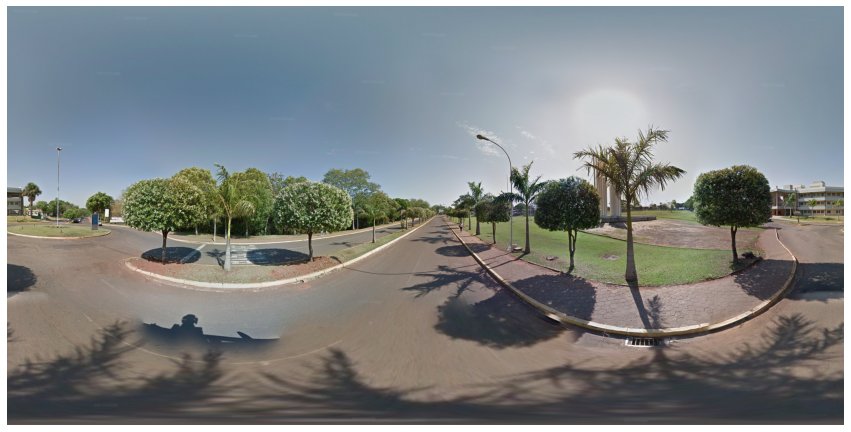

Searching for lat=-20.498319999999996, lon=-54.61257


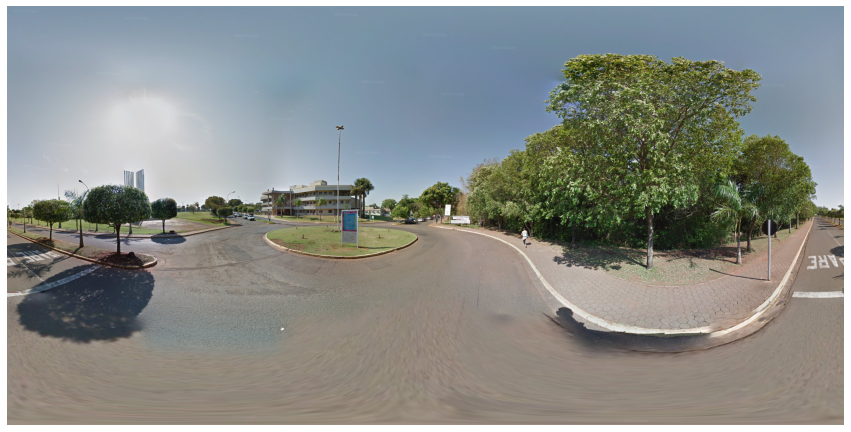

Searching for lat=-20.498349999999995, lon=-54.61257


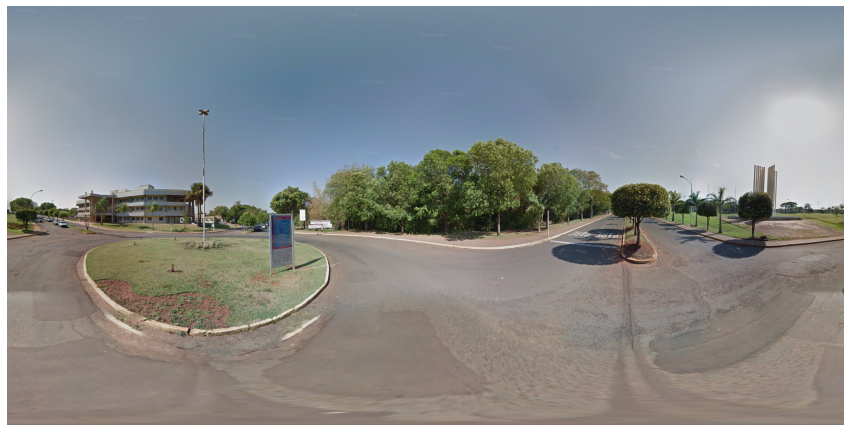

Searching for lat=-20.498379999999994, lon=-54.61257


In [ ]:
# Extract your coordinates from your file
coords = get_lat_long(file_path)

# Download panorama images from your coordinates
download_images(coords, show_img=True, img_dir='./images/', video_dir='./video/')